In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
bs = 16
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Load and Prepare Data

In [5]:
!pwd

/data/intsco/off-sample


In [6]:
gs_path = Path('./GS/raw_images_rect'); gs_path

PosixPath('GS/raw_images_rect')

In [7]:
row_list = []
for ds_path in gs_path.iterdir():
    for cl in ['on', 'off']:
        for p in (ds_path / cl).iterdir():
            row_list.append([str(p), ds_path.name, cl])

df = pd.DataFrame(row_list, columns=['name', 'group', 'label'])
df.shape

(18245, 3)

In [8]:
df.head()

,name,group,label
0,GS/raw_images_rect/AstraZeneca__Rat_testis/on/...,AstraZeneca__Rat_testis,on
1,GS/raw_images_rect/AstraZeneca__Rat_testis/on/...,AstraZeneca__Rat_testis,on
2,GS/raw_images_rect/AstraZeneca__Rat_testis/on/...,AstraZeneca__Rat_testis,on
3,GS/raw_images_rect/AstraZeneca__Rat_testis/on/...,AstraZeneca__Rat_testis,on
4,GS/raw_images_rect/AstraZeneca__Rat_testis/on/...,AstraZeneca__Rat_testis,on


In [9]:
all_groups = list(df.group.unique())
print(len(all_groups))
valid_groups = ['S649 WS21 155x105 15um E110']
train_groups = [g for g in all_groups if g not in valid_groups]

67


In [10]:
len(train_groups), valid_groups

(66, ['S649 WS21 155x105 15um E110'])

In [11]:
def create_data_bunch(train_df, valid_df):
#     train_mask, valid_mask = df.group.isin(train_groups), df.group.isin(valid_groups)
#     train_ds = ImageClassificationDataset(df[train_mask]['name'].values, df[train_mask]['label'].values, classes=['on', 'off'])
#     valid_ds = ImageClassificationDataset(df[valid_mask]['name'].values, df[valid_mask]['label'].values, classes=['on', 'off'])
    train_ds = ImageClassificationDataset(train_df['name'].values, train_df['label'].values, classes=['on', 'off'])
    valid_ds = ImageClassificationDataset(valid_df['name'].values, valid_df['label'].values, classes=['on', 'off'])
    data = ImageDataBunch.create(train_ds, valid_ds, bs=bs, ds_tfms=get_transforms(), size=64)
    data.normalize(data.batch_stats())
    print(data.batch_stats())
    return data

In [12]:
train_mask, valid_mask = df.group.isin(train_groups), df.group.isin(valid_groups)
data = create_data_bunch(df[train_mask], df[valid_mask])

[tensor([-6.9500e-07, -6.9500e-07, -6.9500e-07]), tensor([1., 1., 1.])]


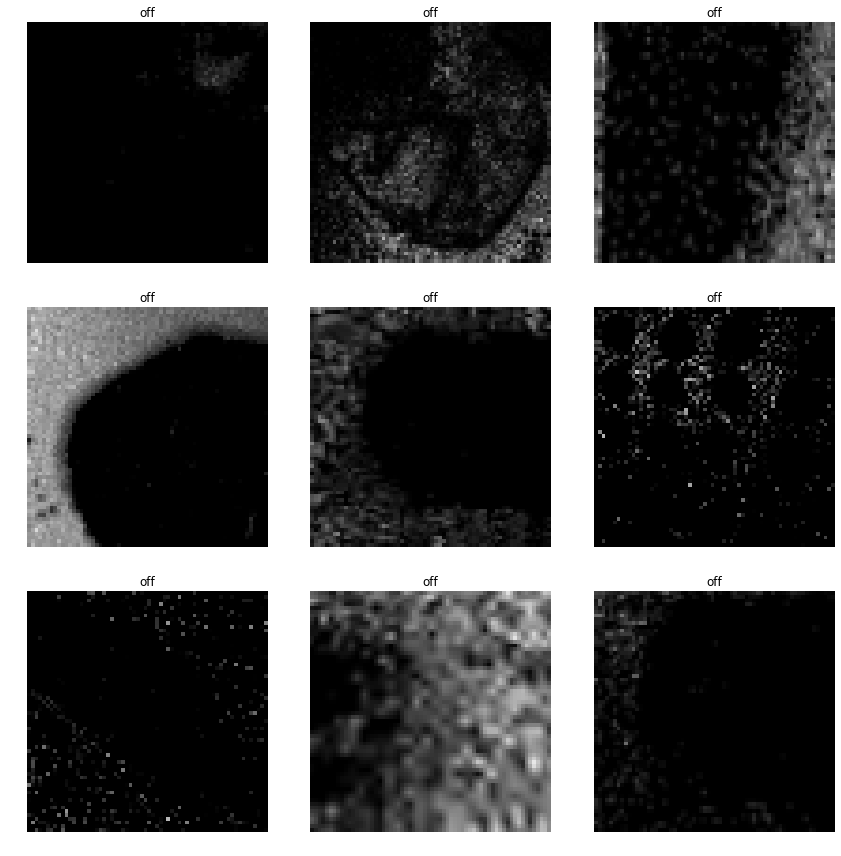

In [13]:
data.show_batch(rows=3, figsize=(12, 12))

In [14]:
print(data.classes)
len(data.classes), data.c

['on', 'off']


(2, 2)

## Training: resnet34

In [30]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [31]:
learn.fit_one_cycle(1)

Total time: 00:56
epoch  train_loss  valid_loss  accuracy
1      0.200104    0.172547    0.938389  (00:56)



In [32]:
learn.save('stage-1')

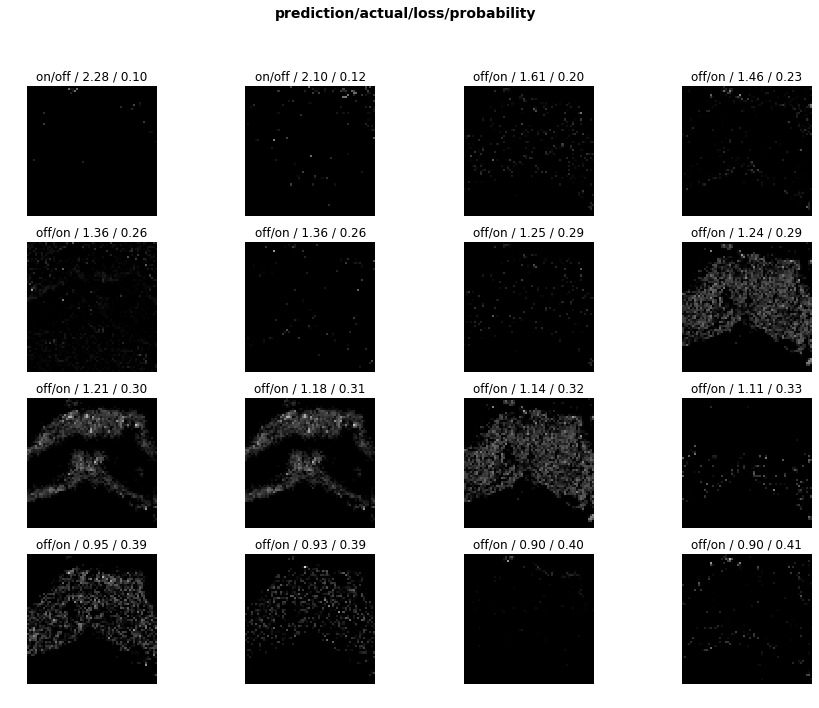

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(16, figsize=(15, 11))

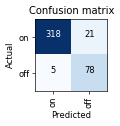

In [34]:
interp.plot_confusion_matrix(figsize=(2, 2), dpi=60)

## Unfreezing, fine-tuning, and andjusing learning rates

#### Unfreeze and completely retrain

In [38]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [39]:
learn.unfreeze()

In [40]:
learn.fit_one_cycle(1)

Total time: 01:24
epoch  train_loss  valid_loss  accuracy
1      0.172661    0.124214    0.971564  (01:24)



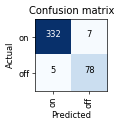

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(2, 2), dpi=60)

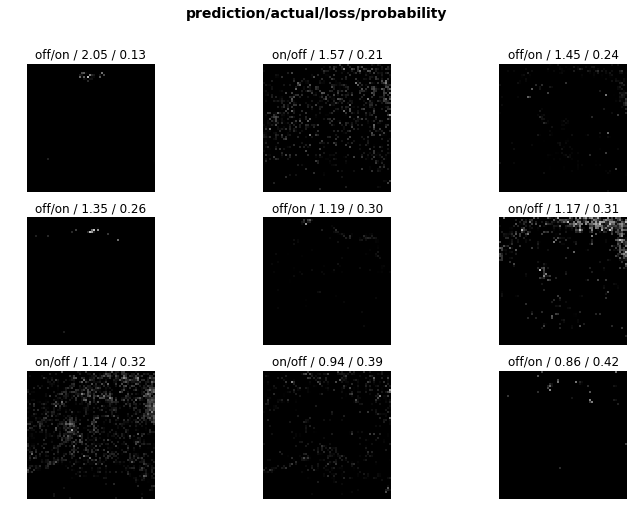

In [42]:
interp.plot_top_losses(9, figsize=(12,8))

#### Unfreeze and fine-tune

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


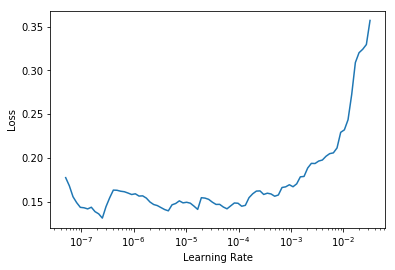

In [27]:
learn.lr_find(start_lr=1e-8, end_lr=1e-1)
learn.recorder.plot()

In [35]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-3))

Total time: 05:37
epoch  train_loss  valid_loss  accuracy
1      0.192755    0.429283    0.774882  (01:24)
2      0.133012    0.165062    0.947867  (01:24)
3      0.079541    0.255995    0.874408  (01:24)
4      0.086077    0.123049    0.959716  (01:24)



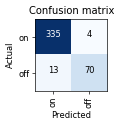

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(2, 2), dpi=60)

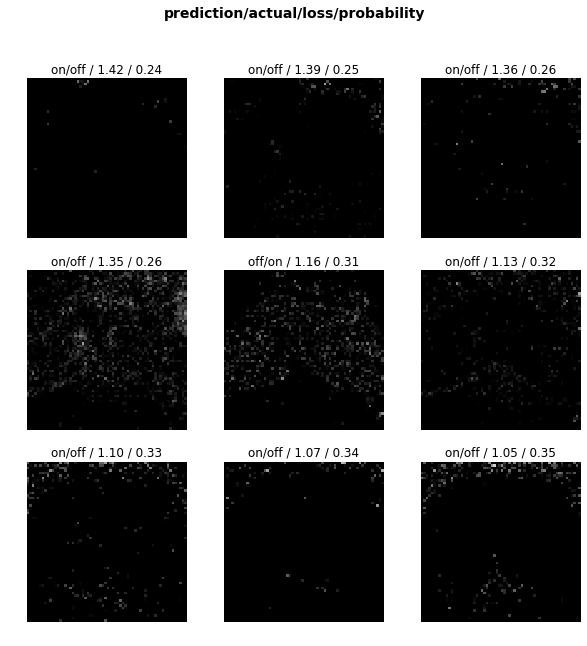

In [37]:
interp.plot_top_losses(9, figsize=(10, 10))

## Training: resnet50

In [80]:
learn = ConvLearner(data, models.resnet50, metrics=accuracy)

In [81]:
# learn.fit_one_cycle(8, max_lr=slice(1e-3))
learn.fit_one_cycle(1)

Total time: 00:36
epoch  train_loss  valid_loss  accuracy
1      0.169731    0.248322    0.898082  (00:36)



In [82]:
learn.save('stage-1-50')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


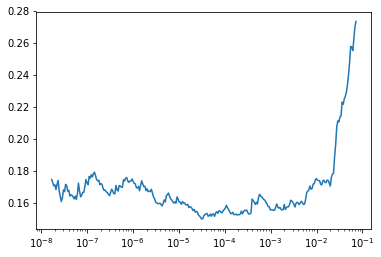

In [83]:
learn.lr_find(start_lr=1e-8, end_lr=1e-1, num_it=200)
learn.recorder.plot()

In [66]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-2))

Total time: 03:35
epoch  train_loss  valid_loss  accuracy
1      0.154210    0.213772    0.931034  (00:53)
2      0.103308    0.114796    0.955665  (00:53)
3      0.073586    0.131933    0.955665  (00:54)
4      0.065947    0.118771    0.970443  (00:54)



In [60]:
# learn.load('stage-1-50')

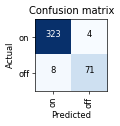

In [67]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(2, 2), dpi=60)

## Cross Validation

In [68]:
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [70]:
def calc_metrics(y_true, y_probs):
    y_pred = np.argmax(np.array(y_probs), axis=1)
    return {
        'acc': accuracy_score(y_true, y_pred),
        'rec': recall_score(y_true, y_pred),
        'prec': precision_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

In [72]:
def create_fit_learner(data):
    learn = ConvLearner(data, models.resnet50, metrics=accuracy)
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-2))
    return learn

In [73]:
%%time

split_n = 5
attempt_n = 5

gkfold = GroupKFold(n_splits=split_n)
metric_list = []

for fold_i, (train_inds, valid_inds) in enumerate(gkfold.split(df, groups=df.group)):
    print(fold_i, train_inds.shape, valid_inds.shape)
    
    train_df, valid_df = df.iloc[train_inds], df.iloc[valid_inds]
    data = create_data_bunch(train_df, valid_df)
    avg_probs = np.zeros((valid_inds.shape[0], 2))
    
    for attempt_i in range(attempt_n):
        learn = create_fit_learner(data)

        interp = ClassificationInterpretation.from_learner(learn)
#         interp.plot_confusion_matrix(figsize=(2, 2), dpi=60)

        d = calc_metrics(interp.y_true, interp.probs)
        d['fold'] = fold_i
        d['attempt'] = attempt_i
        metric_list.append(d)
        avg_probs += np.array(interp.probs)
    
    avg_probs /= attempt_n
    d = calc_metrics(interp.y_true, avg_probs)
    d['fold'] = fold_i
    d['attempt'] = 'avg'
    metric_list.append(d)

CPU times: user 1h 25min 54s, sys: 7min 33s, total: 1h 33min 27s
Wall time: 1h 35min 40s


In [74]:
metric_df = pd.DataFrame(metric_list)
metric_df

,acc,attempt,f1,fold,prec,rec
0,0.977943,0,0.974779,0,0.980964,0.968672
1,0.981252,1,0.978562,0,0.984772,0.972431
2,0.967466,2,0.962204,0,0.984273,0.941103
3,0.972705,3,0.968421,0,0.986355,0.951128
4,0.979322,4,0.976423,0,0.979811,0.973058
5,0.977943,avg,0.974716,0,0.983418,0.966165
6,0.960784,0,0.958763,1,0.959862,0.957666
7,0.973312,1,0.972064,1,0.968750,0.975400
8,0.970861,2,0.969851,1,0.955580,0.984554
9,0.969499,3,0.968091,1,0.964245,0.971968


In [75]:
metric_df[metric_df.attempt == 'avg']

,acc,attempt,f1,fold,prec,rec
5,0.977943,avg,0.974716,0,0.983418,0.966165
11,0.973039,avg,0.971771,1,0.968732,0.974828
17,0.944168,avg,0.936796,2,0.903440,0.972710
23,0.983687,avg,0.983507,3,0.988944,0.978130
29,0.955616,avg,0.948276,4,0.922933,0.975049


In [87]:
df = metric_df[metric_df.attempt == 'avg']
df.agg([np.mean, np.std])

,acc,f1,fold,prec,rec
mean,0.966891,0.963013,2.000000,0.953494,0.973377
std,0.016473,0.019610,1.581139,0.038157,0.004471


In [84]:
metric_df[metric_df.attempt == 'avg'].agg([np.mean, np.std])

,acc,f1,fold,prec,rec
mean,0.966891,0.963013,2.000000,0.953494,0.973377
std,0.016473,0.019610,1.581139,0.038157,0.004471


## Other data formats

In [43]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/.fastai/data/mnist_sample')

In [44]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

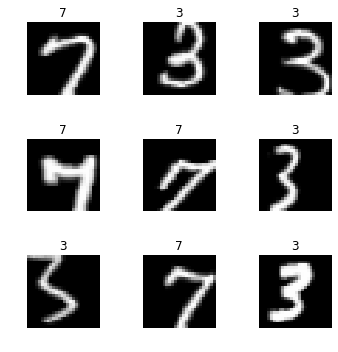

In [45]:
data.show_batch(rows=3, figsize=(5,5))

In [50]:
learn = ConvLearner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:19
epoch  train_loss  valid_loss  accuracy
1      0.112066    0.038564    0.985512  (00:09)
2      0.057227    0.021975    0.991873  (00:09)



In [52]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [58]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

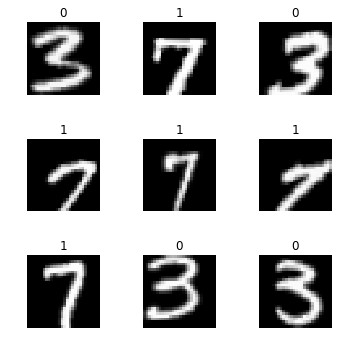

In [59]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [60]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [61]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/train/3/21102.png')]

In [62]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [63]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [64]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [65]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']